In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
import matplotlib.pyplot as plt
import math

In [3]:
import time

In [4]:
df_final = pd.read_pickle("df_final.pkl")


In [5]:
X_df = df_final.drop(columns=['PHQ9'])
feature_names = X_df.columns.tolist()

X = X_df.to_numpy()
y = df_final['PHQ9'].to_numpy()


In [6]:
def grad_F_p(beta, X, y, lam, p):
    """
    Gradient of F_p(beta) = (1/n)*||y - X beta||^2 + lam * sum |beta_j|^p
    valid for p > 1.
    """
    n, d = X.shape

    # Gradient of the loss
    residual = y - X @ beta
    grad_loss = -(2.0 / n) * (X.T @ residual)

    # Gradient of the p-norm regularization
    eps = 1e-8
    abs_beta = np.abs(beta) + eps
    grad_reg = lam * p * (abs_beta ** (p - 1)) * np.sign(beta)

    return grad_loss + grad_reg


In [7]:
def grad_loss(beta, X, y): #for lasso
    n, d = X.shape
    residual = y - X @ beta
    return -(2.0 / n) * X.T @ residual

In [8]:
def F_lasso(beta, X, y, lam):       #computes full objective function of lasso problem
    n, d = X.shape
    residual = y - X @ beta
    loss = (1.0 / n) * np.dot(residual, residual)
    reg  = lam * np.sum(np.abs(beta))
    return loss + reg

In [9]:
def F_p(beta, X, y, lam, p): 
    """
    F_p(beta) = (1/n)||y - X beta||^2 + lam * sum |beta_j|^p
    (for p > 1)
    """
    n, d = X.shape
    residual = y - X @ beta
    loss = (1.0 / n) * np.dot(residual, residual)
    reg  = lam * np.sum(np.abs(beta)**p)
    return loss + reg


In [10]:
def soft_threshold(z, tau):
    # prox_{tau * ||.||_1}(z)
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

In [11]:
def gradient_descent(X, y, lam, p, 
                     lr=1e-3, 
                     max_iter=1000, 
                     tol=1e-6, 
                     beta_init=None, #beta is x
                     store_history=False):

    n, d = X.shape
    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()
    
    history = []
    k_final = max_iter
    
    elapsed_times=[]
    for k in range(max_iter):
        t0 = time.perf_counter()
        g = grad_F_p(beta, X, y, lam, p)
        
        if store_history:
            residual = y - X @ beta
            loss = (1.0 / n) * np.dot(residual, residual) #error cuadratico
            reg = lam * np.sum(np.abs(beta)**p) #regularization
            history.append(loss + reg)
        
        if np.linalg.norm(g) < tol:
            print(f"GD convergió en {k+1} iteraciones.")
            k_final = k + 1
            break
        
         
        beta = beta - lr * g
        
        elapsed_times.append(time.perf_counter() - t0)
    else:
        print("GD alcanzó max_iter sin converger (k = max_iter).")
        k_final = max_iter


    if store_history:
        return beta, history, k_final, np.mean(elapsed_times)
    else:
        return beta, k_final, np.mean(elapsed_times)


In [12]:
def gradient_descent_backtracking(X, y, lam, p, 
                                  lr_init=1e-2,   # step inicial 
                                  rho=0.5,        
                                  c=1e-4,         # parámetro de Armijo
                                  max_iter=1000, 
                                  tol=1e-6, 
                                  beta_init=None,
                                  store_history=False):
    """
        GD with backtracking line search
    """
    n, d = X.shape
    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()
    
    history = [] if store_history else None
    k_final = max_iter
    elapsed_times=[]
    for k in range(max_iter):
        #Gradiente en el punto actual
        t0 = time.perf_counter()
        g = grad_F_p(beta, X, y, lam, p)

        #Valor actual de F
        F_curr = F_p(beta, X, y, lam, p)

        if store_history:
            history.append(F_curr)
        
        if np.linalg.norm(g) < tol:
            print(f"GD (backtracking) convergió en {k+1} iteraciones.")
            k_final = k + 1
            break

        #Backtracking line search
        t = lr_init 

        #Armijo

        g_norm_sq = np.dot(g, g)

        while True:
            beta_candidate = beta - t * g
            F_new = F_p(beta_candidate, X, y, lam, p)

            if F_new <= F_curr - c * t * g_norm_sq:
                break
            else:
                t *= rho
                if t < 1e-12:
                    break

        beta = beta_candidate
        elapsed_times.append(time.perf_counter() - t0)
    else:
        print("GD (backtracking) alcanzó max_iter sin converger.")
        k_final = max_iter
    

    
    if store_history:
        return beta, history, k_final, np.mean(elapsed_times)
    else:
        return beta, k_final, np.mean(elapsed_times)


In [13]:
def nesterov_accelerated_gradient(X, y, lam, p,  
                                  lr=1e-3,
                                  max_iter=1000,
                                  tol=1e-6,
                                  beta_init=None,
                                  store_history=False):
    """
    Nesterov Accelerated Gradient para minimizar F_p.
    """
    n, d = X.shape
    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()
    
    v = beta.copy()
    history = [] if store_history else None
    k_final = max_iter

    t_prev = 1.0


    elapsed_times=[]
    
    for k in range(max_iter):
        t0 = time.perf_counter()
       
        # Gradiente evaluado en el punto adelantado v
        g = grad_F_p(v, X, y, lam, p)
        
        if store_history:
            residual = y - X @ v
            loss = (1.0 / n) * np.dot(residual, residual)
            reg = lam * np.sum(np.abs(v)**p)
            history.append(loss + reg)
        
        if np.linalg.norm(g) < tol:
            print(f"Nesterov convergió en {k} iteraciones.")
            k_final = k + 1
            break
        
        beta_new = v - lr * g
        t_new = 0.5 * (1 + np.sqrt(1 + 4 * t_prev**2))
        momentum = (t_prev - 1.0) / t_new
        v = beta_new + momentum * (beta_new - beta)
        
        beta = beta_new
        t_prev = t_new
        elapsed_times.append(time.perf_counter() - t0)

    else:
        print("Nesterov alcanzó max_iter sin converger.")
        k_final = max_iter
    
    
    if store_history:
        return beta, history, k_final, np.mean(elapsed_times)
    else:
        return beta, k_final, np.mean(elapsed_times)


In [14]:
def subgradient_lasso(X, y, lam,
                      alpha0=1e-3,
                      max_iter=5000,
                      tol=1e-6,
                      beta_init=None,
                      store_history=False):
    n, d = X.shape
    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()

    history = []
    elapsed_times=[]

    for k in range(max_iter):
        t0 = time.perf_counter()
        g_loss = grad_loss(beta, X, y)
        s = np.sign(beta)  
        g = g_loss + lam * s

        alpha_k = alpha0 / np.sqrt(k + 1)  

        beta_new = beta - alpha_k * g

        if store_history:
            history.append(F_lasso(beta_new, X, y, lam))

        # stopping by small change
        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            print(f"Subgradient converged in {k} iterations.")
            break

        beta = beta_new
        elapsed_times.append(time.perf_counter() - t0)



    if store_history:
        return beta, history, np.mean(elapsed_times)
    else:
        return beta, np.mean(elapsed_times)


In [15]:
def fista_lasso(X, y, lam,

                max_iter=5000,
                tol=1e-6,
                beta_init=None,
                store_history=False):
    """
    FISTA: accelerated proximal gradient for Lasso.
    """
    n, d = X.shape

    #Step size
    L = 2.0*np.linalg.norm(X, 2)**2 / n #cte de Lipschitz 
    step = 1.0 / L

    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()

    yk = beta.copy()  
    t_prev = 1.0

    history = []
    elapsed_times=[]

    for k in range(max_iter):
        t0 = time.perf_counter()

        g = grad_loss(yk, X, y)
        z = yk - step * g
        beta_new = soft_threshold(z, step * lam)

        if store_history:
            history.append(F_lasso(beta_new, X, y, lam))

        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            print(f"FISTA converged in {k} iterations.")
            break

        t_new = 0.5 * (1 + np.sqrt(1 + 4 * t_prev**2))
        momentum = (t_prev - 1.0) / t_new
        yk = beta_new + momentum * (beta_new - beta)
        beta = beta_new
        t_prev = t_new
        elapsed_times.append(time.perf_counter() - t0)


    if store_history:
        return beta, history, np.mean(elapsed_times)
    else:
        return beta, np.mean(elapsed_times)


In [16]:
def ista_lasso(X, y, lam,
               max_iter=5000,
               tol=1e-6,
               beta_init=None,
               store_history=False):
    """
    Proximal Gradient (ISTA) for Lasso:
    min (1/n)||y - X beta||^2 + lam * ||beta||_1
    """
    n, d = X.shape
    
    #step size
    L = 2.0*np.linalg.norm(X, 2)**2 / n #cte de Lipschitz ¿2?
    step = 1.0 / L

    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()

    history = []
    elapsed_times=[]

    for k in range(max_iter):
        t0 = time.perf_counter()

        g = grad_loss(beta, X, y)           # grad of smooth part
        z = beta - step * g                   # gradient step
        beta_new = soft_threshold(z, step * lam)  # prox step (L1)

        if store_history:
            history.append(F_lasso(beta_new, X, y, lam))

        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            print(f"ISTA converged in {k} iterations.")
            break

        beta = beta_new
        elapsed_times.append(time.perf_counter() - t0)



    if store_history:
        return beta, history, np.mean(elapsed_times)
    else:
        return beta, np.mean(elapsed_times)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.2, random_state=42
)

In [18]:
lambda_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1]


In [19]:
def mse(X_, y_, beta):
        residual = y_ - X_ @ beta
        return np.mean(residual**2)

## LASSO

In [20]:
results_lasso = []

In [21]:

for lam in lambda_grid:
    beta_sub, hist_sub, t_sub = subgradient_lasso(
        X_train, y_train, lam,
        alpha0=1e-3,
        max_iter=20000,
        tol=1e-6,
        store_history=True
    )
    mse_tr_sub = mse(X_train, y_train, beta_sub)
    mse_te_sub = mse(X_test,  y_test,  beta_sub)
    nnz_sub = np.count_nonzero(beta_sub)

    results_lasso.append({
        "method": "Subgradient",
        "lam": lam,
        "time": t_sub,
        "mse_train": mse_tr_sub,
        "mse_test": mse_te_sub,
        "nnz": nnz_sub,
        "history": hist_sub,
        "beta": beta_sub,
    })

    # ISTA
    beta_ista, hist_ista, t_ista = ista_lasso(
        X_train, y_train, lam,
        max_iter=20000,
        tol=1e-6,
        store_history=True
    )
    mse_tr_ista = mse(X_train, y_train, beta_ista)
    mse_te_ista = mse(X_test,  y_test,  beta_ista)
    nnz_ista = np.count_nonzero(beta_ista)

    results_lasso.append({
        "method": "ISTA",
        "lam": lam,
        "time": t_ista,
        "mse_train": mse_tr_ista,
        "mse_test": mse_te_ista,
        "nnz": nnz_ista,
        "history": hist_ista,
        "beta": beta_ista,


    })

    # FISTA
    beta_fista, hist_fista, t_fista = fista_lasso(
        X_train, y_train, lam,
        max_iter=20000,
        tol=1e-6,
        store_history=True
    )
    mse_tr_fista = mse(X_train, y_train, beta_fista)
    mse_te_fista = mse(X_test,  y_test,  beta_fista)
    nnz_fista = np.count_nonzero(beta_fista)

    results_lasso.append({
        "method": "FISTA",
        "lam": lam,
        "time": t_fista,
        "mse_train": mse_tr_fista,
        "mse_test": mse_te_fista,
        "nnz": nnz_fista,
        "history": hist_fista,
        "beta": beta_fista,

    })


FISTA converged in 12513 iterations.
FISTA converged in 8606 iterations.
ISTA converged in 3942 iterations.
FISTA converged in 1552 iterations.


In [22]:
lam_ref = 0.01

betas_lam = {}
for res in results_lasso:
    if np.isclose(res["lam"], lam_ref):
        betas_lam[res["method"]] = res["beta"]


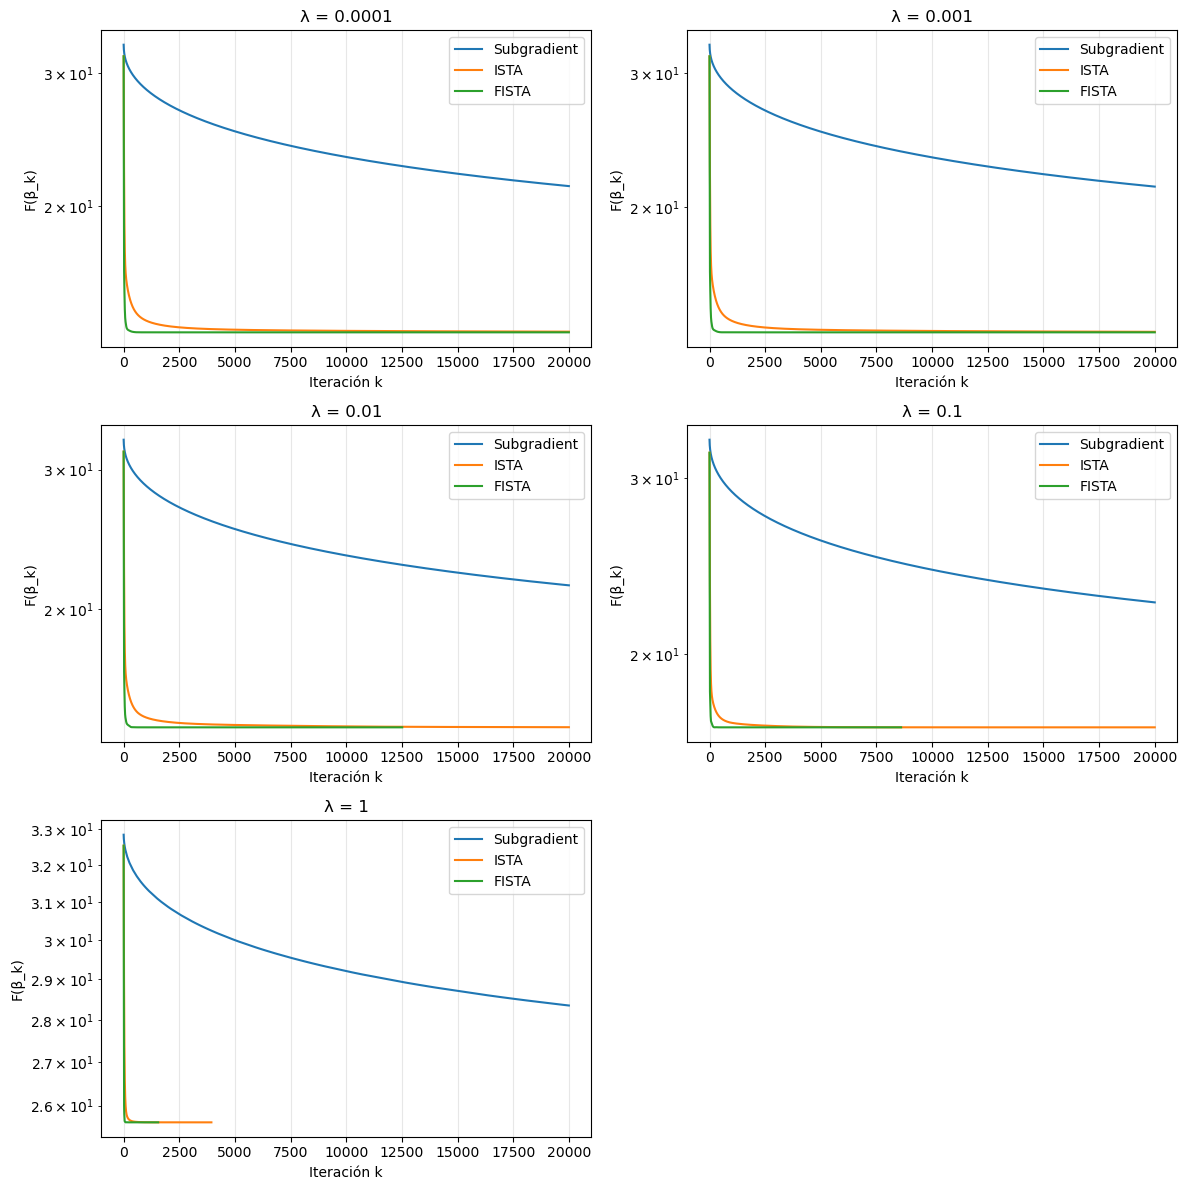

In [23]:
lams = sorted(list(set([res["lam"] for res in results_lasso])))

n_lams = len(lams)
n_cols = 2
n_rows = math.ceil(n_lams / n_cols)

plt.figure(figsize=(12, 4*n_rows))

for i, lam in enumerate(lams):
    plt.subplot(n_rows, n_cols, i+1)
    
    for res in results_lasso:
        if res["lam"] == lam:
            plt.plot(res["history"], label=res["method"])
    
    plt.title(f"λ = {lam}")
    plt.xlabel("Iteración k")
    plt.ylabel("F(β_k)")
    plt.yscale("log")
    #plt.xscale("log")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

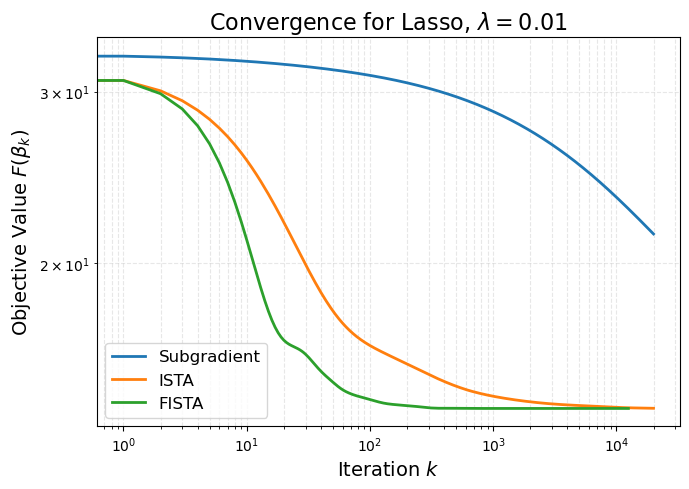

In [24]:
lam = 0.01
results_lam = [res for res in results_lasso if res["lam"] == lam]

plt.figure(figsize=(7,5))

for res in results_lam:
    plt.plot(
        res["history"], 
        label=res["method"], 
        linewidth=2
    )

plt.title(r"Convergence for Lasso, $\lambda = 0.01$", fontsize=16)
plt.xlabel("Iteration $k$", fontsize=14)
plt.ylabel(r"Objective Value $F(\beta_k)$", fontsize=14)

plt.yscale("log")
plt.xscale('log')
plt.grid(True, which="both", linestyle="--", alpha=0.3)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


## intermediate P's

In [25]:
import time
results_p_intermediate = []

for p in [1.2, 1.5, 1.8]:
    for lam in lambda_grid:

        # GD
        beta_gd, hist_gd,_, t_gd = gradient_descent(
            X_train, y_train, lam=lam, p=p,
            lr=5e-3, max_iter=20000, tol=1e-6,
            store_history=True
        )
        results_p_intermediate.append({
            "p": p,
            "method": "GD",
            "lam": lam,
            "time": t_gd,
            "history": hist_gd,
            "mse_train": mse(X_train, y_train, beta_gd),
            "mse_test": mse(X_test, y_test, beta_gd),
            "nnz": np.count_nonzero(beta_gd),
            "beta": beta_gd,
        })

        # GD backtracking
        beta_bt, hist_bt, _,t_bt = gradient_descent_backtracking(
            X_train, y_train, lam=lam, p=p,
            lr_init=1e-2, max_iter=20000, tol=1e-6,
            store_history=True
        )
        results_p_intermediate.append({
            "p": p,
            "method": "GD_BT",
            "lam": lam,
            "time": t_bt,
            "history": hist_bt,
            "mse_train": mse(X_train, y_train, beta_bt),
            "mse_test": mse(X_test, y_test, beta_bt),
            "nnz": np.count_nonzero(beta_bt),
            "beta": beta_bt,
        })

        # Nesterov
        beta_nest, hist_nest,_, t_nest = nesterov_accelerated_gradient(
            X_train, y_train, lam=lam, p=p,
            lr=5e-3, max_iter=20000, tol=1e-6,
            store_history=True
        )
        results_p_intermediate.append({
            "p": p,
            "method": "Nesterov",
            "lam": lam,
            "time": t_nest,
            "history": hist_nest,
            "mse_train": mse(X_train, y_train, beta_nest),
            "mse_test": mse(X_test, y_test, beta_nest),
            "nnz": np.count_nonzero(beta_nest),
            "beta": beta_nest,
        })


GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó ma

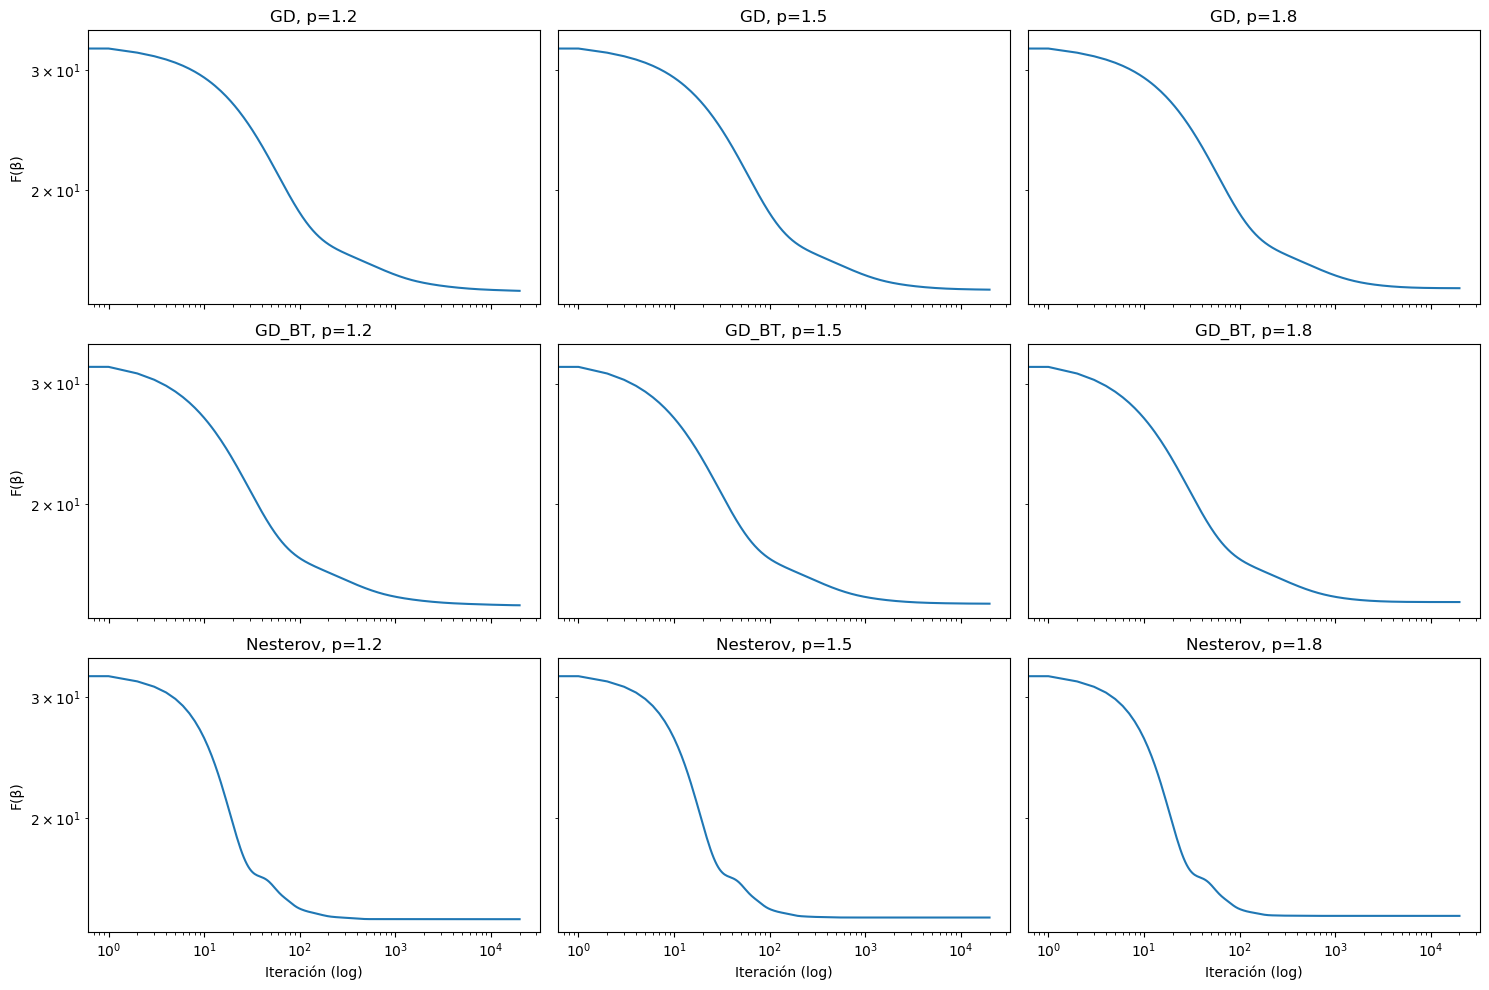

In [26]:

p_values = [1.2, 1.5, 1.8]
methods_plot = ["GD", "GD_BT", "Nesterov"]
lam_plot = 0.01

fig, axes = plt.subplots(len(methods_plot), len(p_values),
                         figsize=(15, 10),
                         sharex=True, sharey=True)

for i, method in enumerate(methods_plot):
    for j, p in enumerate(p_values):

        ax = axes[i, j]

        # buscar datos
        for res in results_p_intermediate:
            if res["p"] == p and math.isclose(res["lam"], lam_plot) and res["method"] == method:
                ax.plot(res["history"])
                break

        ax.set_yscale("log")
        ax.set_xscale("log")
        if i == len(methods_plot)-1:
            ax.set_xlabel("Iteración (log)")
        if j == 0:
            ax.set_ylabel("F(β)")
        ax.set_title(f"{method}, p={p}")

plt.tight_layout()
plt.show()


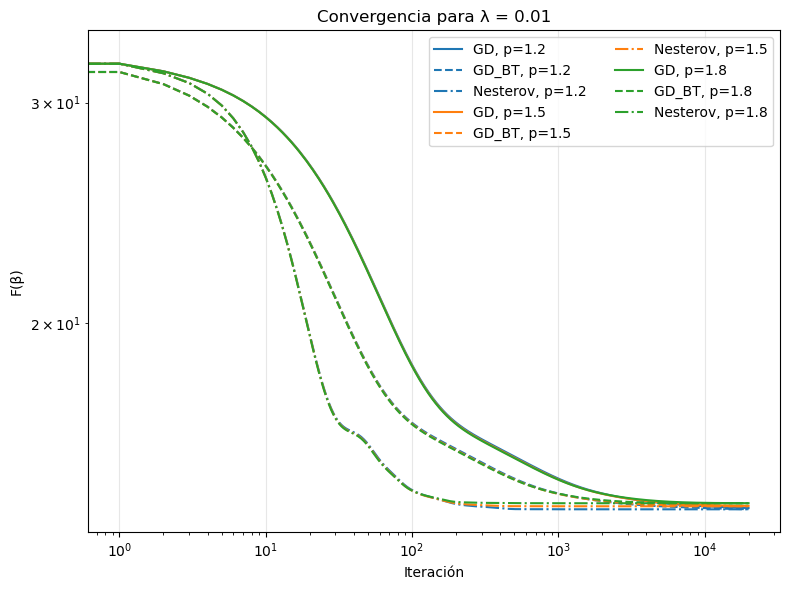

In [27]:


colors = {1.2:"C0", 1.5:"C1", 1.8:"C2"}
linestyles = {"GD":"-", "GD_BT":"--", "Nesterov":"-."}
lam_plot = 0.01

plt.figure(figsize=(8,6))

for res in results_p_intermediate:
    if math.isclose(res["lam"], lam_plot):
        p = res["p"]
        method = res["method"]
        plt.plot(
            res["history"],
            color=colors[p],
            linestyle=linestyles[method],
            label=f"{method}, p={p}"
        )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Iteración")
plt.ylabel("F(β)")
plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.title(f"Convergencia para λ = {lam_plot}")
plt.tight_layout()
plt.show()


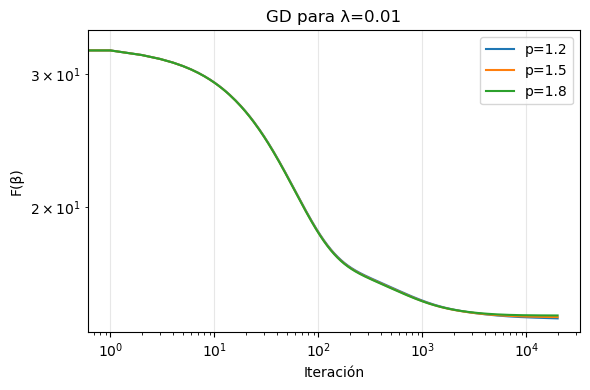

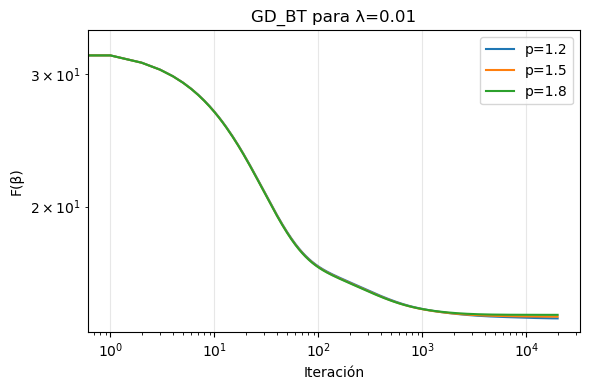

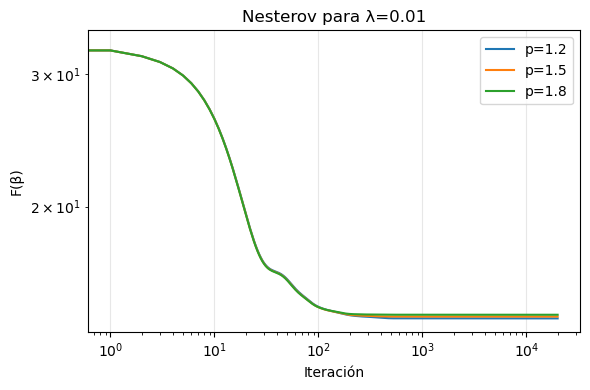

In [28]:
methods_plot = ["GD", "GD_BT", "Nesterov"]
p_values = [1.2, 1.5, 1.8]
lam_plot = 0.01

for method in methods_plot:
    plt.figure(figsize=(6,4))
    for p in p_values:
        for res in results_p_intermediate:
            if res["method"]==method and res["p"]==p and math.isclose(res["lam"], lam_plot):
                plt.plot(res["history"], label=f"p={p}")
                break
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Iteración")
    plt.ylabel("F(β)")
    plt.title(f"{method} para λ={lam_plot}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


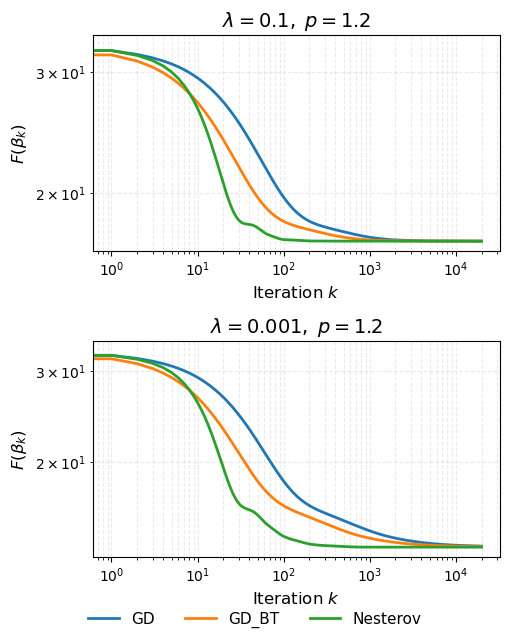

In [29]:
import matplotlib.pyplot as plt

p_target = 1.2
lams_to_plot = [0.1, 0.001]

fig, axes = plt.subplots(
    2, 1, figsize=(5.2, 6.6),   
    sharex=False, sharey=False
)

for ax, lam in zip(axes, lams_to_plot):

    for res in results_p_intermediate:
        if res["lam"] == lam and res["p"] == p_target:
            ax.plot(res["history"], label=res["method"], linewidth=2)

    ax.set_title(r"$\lambda = " + f"{lam}" + r",\; p = 1.2$", fontsize=14)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Iteration $k$", fontsize=12)
    ax.set_ylabel(r"$F(\beta_k)$", fontsize=12)

    ax.grid(True, which="both", linestyle="--", alpha=0.25)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=11, frameon=False,
           bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.savefig("subplot_vertical_p12.png", dpi=300, bbox_inches="tight")
plt.show()


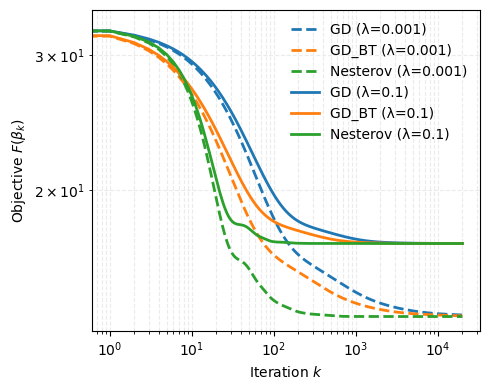

In [30]:
p_target = 1.2
lams_to_plot = [0.1, 0.001]

line_styles = {
    0.1: "-",
    0.001: "--"
}

method_colors = {
    "GD": "#1f77b4",       
    "GD_BT": "#ff7f0e",    
    "Nesterov": "#2ca02c",   
}

fig, ax = plt.subplots(figsize=(5, 4))

for res in results_p_intermediate:
    if res["p"] == p_target and res["lam"] in lams_to_plot:

        method = res["method"]
        color = method_colors.get(method, "black")  
        ls = line_styles[res["lam"]]               

        label = f"{method} (λ={res['lam']})"
        ax.plot(
            res["history"],
            label=label,
            linestyle=ls,
            linewidth=2,
            color=color
        )

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", alpha=0.25)

ax.set_xlabel(r"Iteration $k$")
ax.set_ylabel(r"Objective $F(\beta_k)$")

ax.legend(fontsize=10, frameon=False)

plt.tight_layout()
plt.savefig("merged_p12_trajs.png", dpi=300, bbox_inches="tight")
plt.show()


## RIDGE

In [31]:
p_ridge = 2.0
results_ridge = []
import time
for lam in lambda_grid:
    # --- GD ---
    beta_gd, hist_gd, _, t_gd = gradient_descent(
        X_train, y_train,
        lam=lam, p=p_ridge,
        lr=5e-3,            
        max_iter=20000,
        tol=1e-6,
        store_history=True
    )
    results_ridge.append({
        "method": "GD",
        "lam": lam,
        "time": t_gd,
        "history": hist_gd,
        "mse_train": mse(X_train, y_train, beta_gd),
        "mse_test": mse(X_test,  y_test,  beta_gd),
        "nnz": np.count_nonzero(beta_gd),
        "beta": beta_gd,
    })

    # --- GD con backtracking ---
    beta_bt, hist_bt, _, t_bt = gradient_descent_backtracking(
        X_train, y_train,
        lam=lam, p=p_ridge,
        lr_init=1e-2,
        max_iter=20000,
        tol=1e-6,
        store_history=True
    )
    results_ridge.append({
        "method": "GD_BT",
        "lam": lam,
        "time": t_bt,
        "history": hist_bt,
        "mse_train": mse(X_train, y_train, beta_bt),
        "mse_test": mse(X_test,  y_test,  beta_bt),
        "nnz": np.count_nonzero(beta_bt),
        "beta": beta_bt,
    })

    # --- Nesterov ---
    beta_nest, hist_nest, _, t_nest = nesterov_accelerated_gradient(
        X_train, y_train,
        lam=lam, p=p_ridge,
        lr=5e-3,
        max_iter=20000,
        tol=1e-6,
        store_history=True
    )
    results_ridge.append({
        "method": "Nesterov",
        "lam": lam,
        "time": t_nest,
        "history": hist_nest,
        "mse_train": mse(X_train, y_train, beta_nest),
        "mse_test": mse(X_test,  y_test,  beta_nest),
        "nnz": np.count_nonzero(beta_nest),
        "beta": beta_nest,
    })


GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD alcanzó max_iter sin converger (k = max_iter).
GD (backtracking) alcanzó max_iter sin converger.
Nesterov alcanzó max_iter sin converger.
GD convergió en 10695 iteraciones.
GD (backtracking) convergió en 5345 iteraciones.
Nesterov convergió en 6870 iteraciones.
GD convergió en 1270 iteraciones.
GD (backtracking) convergió en 632 iteraciones.
Nesterov convergió en 1215 iteraciones.


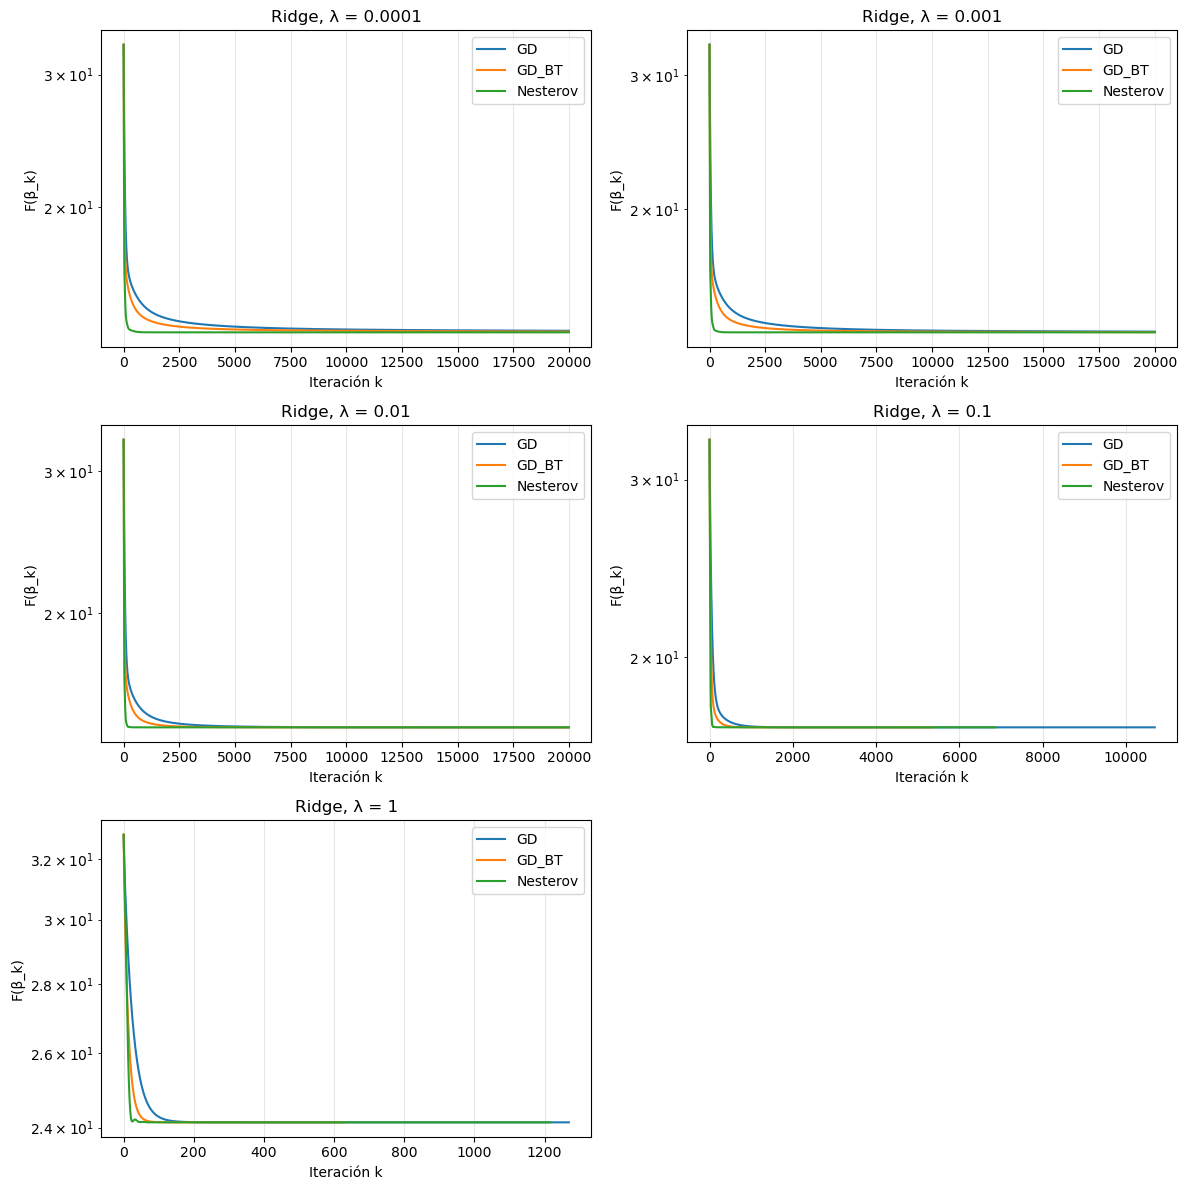

In [32]:
lams = sorted(list(set(res["lam"] for res in results_ridge)))
methods_plot = ["GD", "GD_BT", "Nesterov"]

n_lams = len(lams)
n_cols = 2
n_rows = math.ceil(n_lams / n_cols)

plt.figure(figsize=(12, 4*n_rows))

for i, lam in enumerate(lams):
    plt.subplot(n_rows, n_cols, i+1)
    for m in methods_plot:
        for res in results_ridge:
            if res["lam"] == lam and res["method"] == m:
                plt.plot(res["history"], label=m)
                break
    plt.yscale("log")
    #plt.xscale("log")
    plt.xlabel("Iteración k")
    plt.ylabel("F(β_k)")
    plt.title(f"Ridge, λ = {lam}")
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()


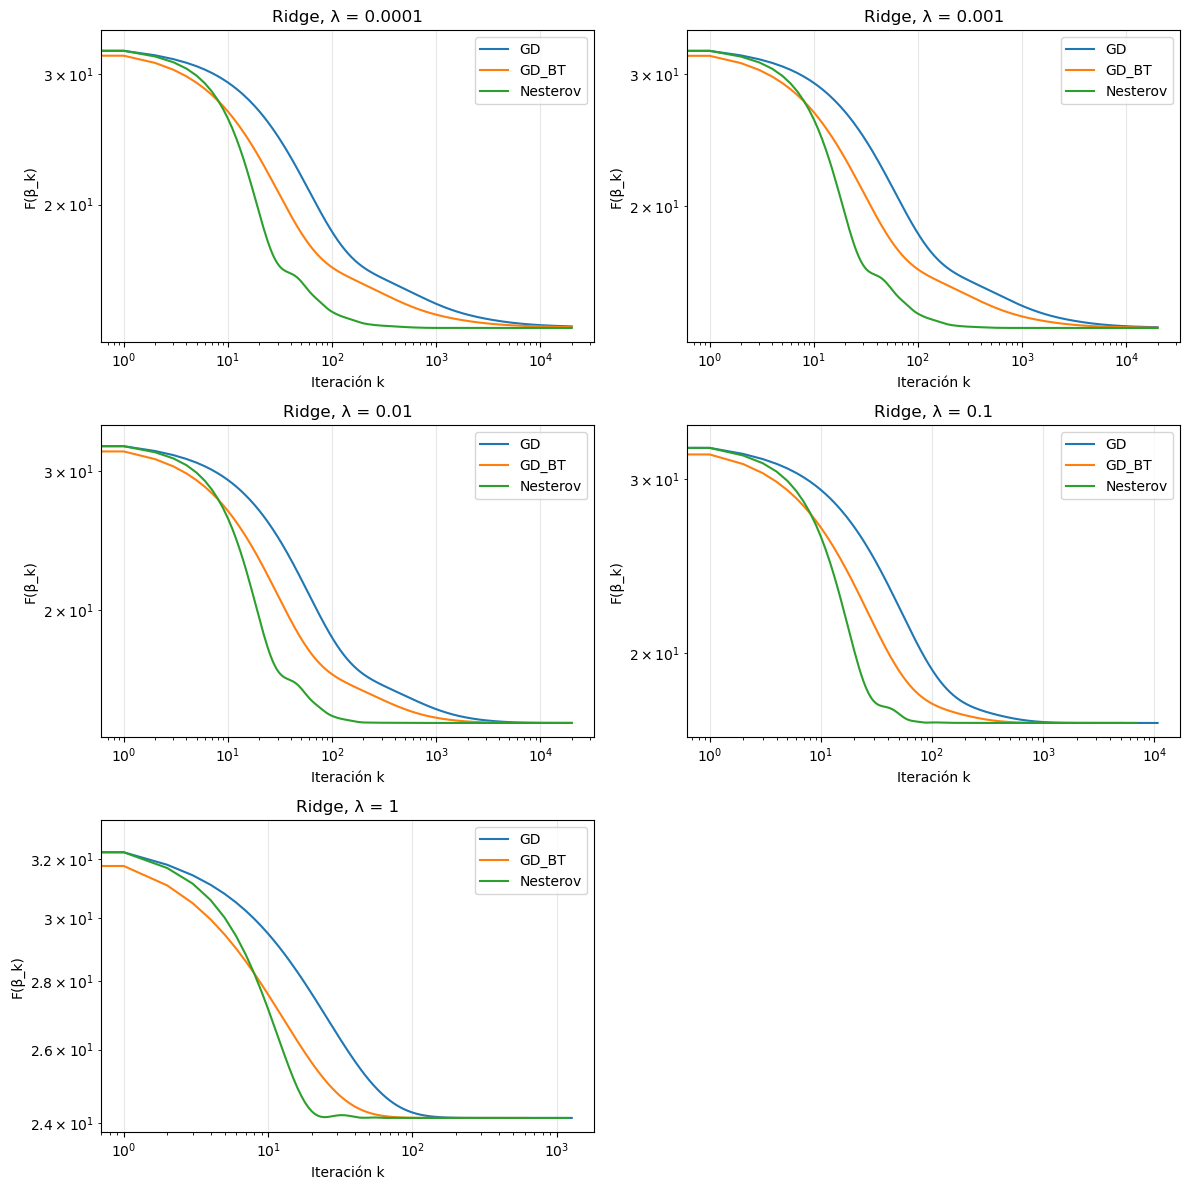

In [33]:
lams = sorted(list(set(res["lam"] for res in results_ridge)))
methods_plot = ["GD", "GD_BT", "Nesterov"]

n_lams = len(lams)
n_cols = 2
n_rows = math.ceil(n_lams / n_cols)

plt.figure(figsize=(12, 4*n_rows))

for i, lam in enumerate(lams):
    plt.subplot(n_rows, n_cols, i+1)
    for m in methods_plot:
        for res in results_ridge:
            if res["lam"] == lam and res["method"] == m:
                plt.plot(res["history"], label=m)
                break
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Iteración k")
    plt.ylabel("F(β_k)")
    plt.title(f"Ridge, λ = {lam}")
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()


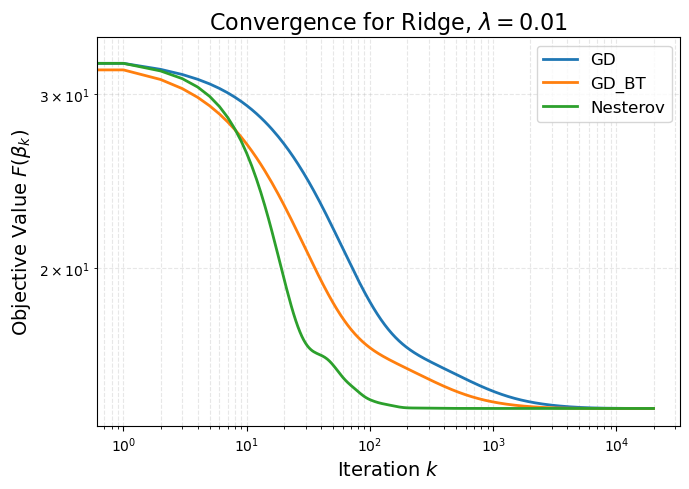

In [34]:

lam_target = 0.01
methods_plot = ["GD", "GD_BT", "Nesterov"]

plt.figure(figsize=(7, 5))

for m in methods_plot:
    res_match = [res for res in results_ridge 
                 if res["lam"] == lam_target and res["method"] == m]
    if len(res_match) > 0:
        plt.plot(res_match[0]["history"], label=m, linewidth=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"Iteration $k$", fontsize=14)
plt.ylabel(r"Objective Value $F(\beta_k)$", fontsize=14)
plt.title(r"Convergence for Ridge, $\lambda = 0.01$", fontsize=16)

plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("ridge_p2_lambda001.png", dpi=300)
plt.show()


## ELASTIC NET

In [35]:
def F_elasticnet(beta, X, y, lam, alpha):
    """
    F(β) = (1/n)||y - Xβ||^2 + lam * ( alpha * ||β||_1 + (1-alpha) * ||β||_2^2 )
    """
    n, d = X.shape
    residual = y - X @ beta
    loss = (1.0 / n) * residual @ residual
    reg_l1 = lam * alpha * np.sum(np.abs(beta))
    reg_l2 = lam * (1 - alpha) * np.sum(beta**2)
    return loss + reg_l1 + reg_l2


def grad_loss_elastic(beta, X, y, lam, alpha):
    """
    Gradiente de la parte suave:
      f(β) = (1/n)||y - Xβ||^2 + lam*(1-alpha)||β||_2^2
    """
    n, d = X.shape
    residual = y - X @ beta
    grad_loss = -(2.0 / n) * X.T @ residual
    grad_l2   = 2.0 * lam * (1 - alpha) * beta
    return grad_loss + grad_l2


In [36]:
def subgradient_elasticnet(X, y, lam, alpha,
                           alpha0=1e-2,
                           max_iter=5000,
                           tol=1e-6,
                           beta_init=None,
                           store_history=False):
    """
    Subgradient descent for Elastic Net:
      (1/n)||y - Xβ||^2 + lam * (alpha * ||β||_1 + (1-alpha)||β||_2^2)
    """
    n, d = X.shape
    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()

    history = []
    t0 = time.perf_counter()

    for k in range(max_iter):
        g_smooth = grad_loss_elastic(beta, X, y, lam, alpha)

        s = np.sign(beta)   
        g = g_smooth + lam * alpha * s

        alpha_k = alpha0 / np.sqrt(k + 1)  

        beta_new = beta - alpha_k * g

        if store_history:
            history.append(F_elasticnet(beta_new, X, y, lam, alpha))

        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            print(f"Subgradient ElasticNet converged in {k} iterations.")
            break

        beta = beta_new

    t1 = time.perf_counter()
    elapsed = t1 - t0

    if store_history:
        return beta, history, elapsed
    else:
        return beta, elapsed


In [37]:
def ista_elasticnet(X, y, lam, alpha,
                    max_iter=5000,
                    tol=1e-6,
                    beta_init=None,
                    store_history=False):
    """
    ISTA for Elastic Net:
    min (1/n)||y-Xβ||^2 + lam*(alpha*||β||_1 + (1-alpha)||β||_2^2)
    """
    n, d = X.shape


    L_X = np.linalg.norm(X, 2)**2
    L = (2.0 / n) * L_X + 2.0 * lam * (1 - alpha)
    step = 1.0 / L

    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()

    history = []
    t0 = time.perf_counter()

    for k in range(max_iter):
        g = grad_loss_elastic(beta, X, y, lam, alpha)
        z = beta - step * g

        beta_new = soft_threshold(z, step * lam * alpha)

        if store_history:
            history.append(F_elasticnet(beta_new, X, y, lam, alpha))

        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            print(f"ISTA ElasticNet converged in {k} iterations.")
            break

        beta = beta_new

    t1 = time.perf_counter()
    elapsed = t1 - t0

    if store_history:
        return beta, history, elapsed
    else:
        return beta, elapsed


In [38]:
def fista_elasticnet(X, y, lam, alpha,
                     max_iter=5000,
                     tol=1e-6,
                     beta_init=None,
                     store_history=False):
    """
    FISTA for Elastic Net:
      min (1/n)||y - Xβ||^2 + lam*(alpha*||β||_1 + (1-alpha)||β||_2^2)

    """
    n, d = X.shape

    L_X = np.linalg.norm(X, 2)**2
    L = (2.0 / n) * L_X + 2.0 * lam * (1 - alpha)
    step = 1.0 / L

    if beta_init is None:
        beta = np.zeros(d)
    else:
        beta = beta_init.copy()

    yk = beta.copy()
    t_prev = 1.0

    history = []
    t0 = time.perf_counter()

    for k in range(max_iter):
        g = grad_loss_elastic(yk, X, y, lam, alpha)

        z = yk - step * g

        beta_new = soft_threshold(z, step * lam * alpha)

        if store_history:
            history.append(F_elasticnet(beta_new, X, y, lam, alpha))

        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            print(f"FISTA ElasticNet converged in {k} iterations.")
            break

        t_new = 0.5 * (1 + np.sqrt(1 + 4.0 * t_prev**2))
        momentum = (t_prev - 1.0) / t_new

        yk = beta_new + momentum * (beta_new - beta)
        beta = beta_new
        t_prev = t_new

    t1 = time.perf_counter()
    elapsed = t1 - t0

    if store_history:
        return beta, history, elapsed
    else:
        return beta, elapsed


In [39]:
import time
results_en = []

lambda_grid = [0.001, 0.01, 0.1, 1]
alpha_grid = [0.2, 0.5, 0.8]

for lam in lambda_grid:
    for alpha in alpha_grid:

        # --- Subgradient ---
        beta_sg, hist_sg, t_sg = subgradient_elasticnet(
            X_train, y_train,
            lam=lam, alpha=alpha,
            max_iter=20000,
            tol=1e-6,
            store_history=True
        )

        results_en.append({
            "method": "Subgradient",
            "lam": lam,
            "alpha": alpha,
            'hist':hist_sg,
            "iters": len(hist_sg),
            "time": t_sg,
            "F_final": hist_sg[-1],
            "mse_train": mse(X_train, y_train, beta_sg),
            "mse_test": mse(X_test, y_test, beta_sg),
            "nnz": np.count_nonzero(beta_sg),
            "beta": beta_sg, 
        })

        # --- ISTA ---
        beta_ista, hist_ista, t_ista = ista_elasticnet(
            X_train, y_train,
            lam=lam, alpha=alpha,
            max_iter=20000,
            tol=1e-6,
            store_history=True
        )

        results_en.append({
            "method": "ISTA",
            "lam": lam,
            "alpha": alpha,
            'hist':hist_ista,
            "iters": len(hist_ista),
            "time": t_ista,
            "F_final": hist_ista[-1],
            "mse_train": mse(X_train, y_train, beta_ista),
            "mse_test": mse(X_test, y_test, beta_ista),
            "nnz": np.count_nonzero(beta_ista),
            "beta": beta_ista, 
        })

        # --- FISTA ---
        beta_fista, hist_fista, t_fista = fista_elasticnet(
            X_train, y_train,
            lam=lam, alpha=alpha,
            max_iter=20000,
            tol=1e-6,
            store_history=True
        )

        results_en.append({
            "method": "FISTA",
            "lam": lam,
            "alpha": alpha,
            'hist':hist_fista,
            "iters": len(hist_fista),
            "time": t_fista,
            "F_final": hist_fista[-1],
            "mse_train": mse(X_train, y_train, beta_fista),
            "mse_test": mse(X_test, y_test, beta_fista),
            "nnz": np.count_nonzero(beta_fista),
            "beta": beta_fista, 
        })


FISTA ElasticNet converged in 14152 iterations.
FISTA ElasticNet converged in 14368 iterations.
FISTA ElasticNet converged in 17937 iterations.
ISTA ElasticNet converged in 3478 iterations.
FISTA ElasticNet converged in 3053 iterations.
ISTA ElasticNet converged in 5429 iterations.
FISTA ElasticNet converged in 3511 iterations.
ISTA ElasticNet converged in 10649 iterations.
FISTA ElasticNet converged in 5257 iterations.
ISTA ElasticNet converged in 440 iterations.
FISTA ElasticNet converged in 462 iterations.
ISTA ElasticNet converged in 670 iterations.
FISTA ElasticNet converged in 685 iterations.
ISTA ElasticNet converged in 1279 iterations.
FISTA ElasticNet converged in 962 iterations.


### sparsity vs alpha

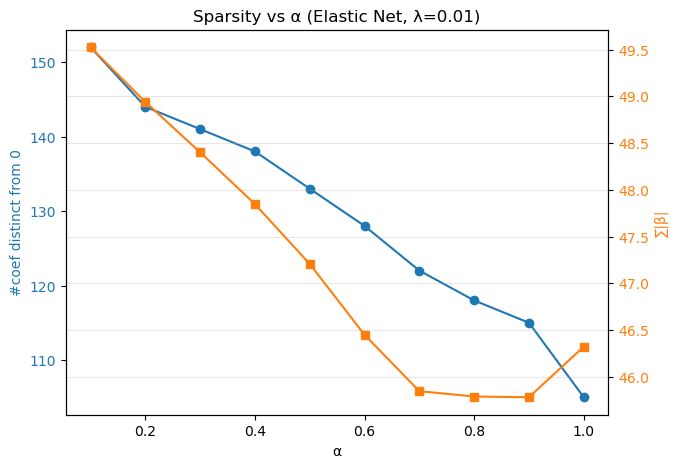

In [40]:
lam_ref = 0.01
alpha_values = np.linspace(0.1, 1.0, 10)

nnz_list = []
sumabs_list = []

for alpha in alpha_values:
    beta, _= fista_elasticnet(X_train, y_train, lam_ref, alpha, store_history=False)
    nnz_list.append(np.count_nonzero(beta))
    sumabs_list.append(np.sum(np.abs(beta)))

fig, ax1 = plt.subplots(figsize=(7,5))

ax1.plot(alpha_values, nnz_list, "-o", color="C0")
ax1.set_xlabel("α")
ax1.set_ylabel("#coef distinct from 0", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")

ax2 = ax1.twinx()
ax2.plot(alpha_values, sumabs_list, "-s", color="C1")
ax2.set_ylabel("∑|β|", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

plt.title(f"Sparsity vs α (Elastic Net, λ={lam_ref})")
plt.grid(alpha=0.3)
plt.show()



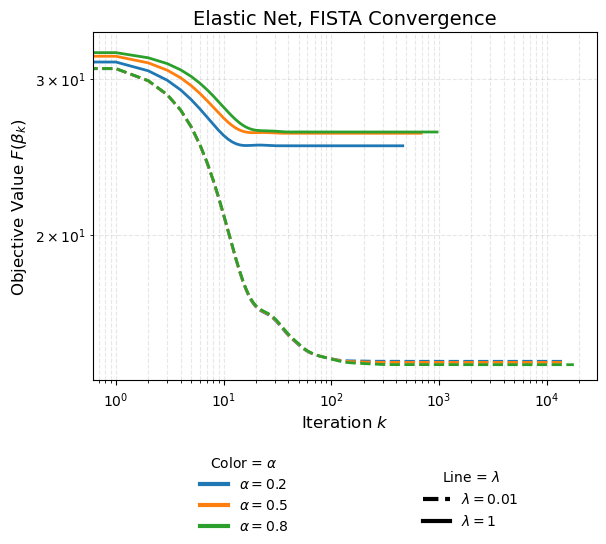

In [41]:
alpha_values = [0.2, 0.5, 0.8]
lams_to_plot=[0.01, 1]

line_styles = {
    1: "-",
    0.01: "--",
}

alpha_colors = {
    0.2: "#1f77b4",  # azul
    0.5: "#ff7f0e",  # naranja
    0.8: "#2ca02c",  # verde
}
method_target = "FISTA"

fig, ax = plt.subplots(figsize=(6.5, 6))

for lam in lams_to_plot:
    for alpha in alpha_values:

        matches = [
            res for res in results_en
            if res["lam"] == lam
            and res["alpha"] == alpha
            and res["method"] == method_target
        ]
        if not matches:
            continue

        hist = matches[0]["hist"]

        ax.plot(
            hist,
            linestyle=line_styles[lam],
            color=alpha_colors[alpha],
            linewidth=2
        )

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", alpha=0.3)

ax.set_xlabel(r"Iteration $k$", fontsize=12)
ax.set_ylabel(r"Objective Value $F(\beta_k)$", fontsize=12)
ax.set_title(r"Elastic Net, FISTA Convergence", fontsize=14)

alpha_handles = [
    plt.Line2D([0], [0], color=alpha_colors[a], lw=3)
    for a in alpha_values
]
alpha_labels = [fr"$\alpha={a}$" for a in alpha_values]

lambda_handles = [
    plt.Line2D([0], [0], color="black", lw=3, linestyle=line_styles[l])
    for l in lams_to_plot
]
lambda_labels = [fr"$\lambda={l}$" for l in lams_to_plot]

legend_alpha = ax.legend(
    alpha_handles, alpha_labels,
    title=r"Color = $\alpha$",
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.3, -0.18)
)
ax.add_artist(legend_alpha)

legend_lambda = ax.legend(
    lambda_handles, lambda_labels,
    title=r"Line = $\lambda$",
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.75, -0.22)
)

plt.subplots_adjust(bottom=0.3)
plt.show()


In [42]:
lam_target = 0.01
p_values = sorted({res["p"] for res in results_p_intermediate})

betas_p_dict = {}

# p intermedios
for p in p_values:
    cand = [res for res in results_p_intermediate
            if res["p"] == p and res["lam"] == lam_target]
    if not cand:
        continue 
    best = min(cand, key=lambda r: r["mse_test"])
    betas_p_dict[p] = best["beta"]

# LASSO (p=1.0)
cand_lasso = [res for res in results_lasso
              if res["lam"] == lam_target and res["method"] == "FISTA"]
best_lasso = min(cand_lasso, key=lambda r: r["mse_test"])
betas_p_dict[1.0] = best_lasso["beta"]

# RIDGE (p=2.0)
cand_ridge = [res for res in results_ridge
              if res["lam"] == lam_target and res["method"] == "Nesterov"]
best_ridge = min(cand_ridge, key=lambda r: r["mse_test"])
betas_p_dict[2.0] = best_ridge["beta"]


In [43]:
betas_en = {}

alpha_values = sorted({res["alpha"] for res in results_en})
method_target = "FISTA"

for alpha in alpha_values:
    cand = [res for res in results_en
            if res["alpha"] == alpha
            and res["lam"] == lam_target
            and res["method"] == method_target]
    if not cand:
        continue
    
    best = min(cand, key=lambda r: r["mse_test"])
    betas_en[rf"$\alpha={alpha}$"] = best["beta"]


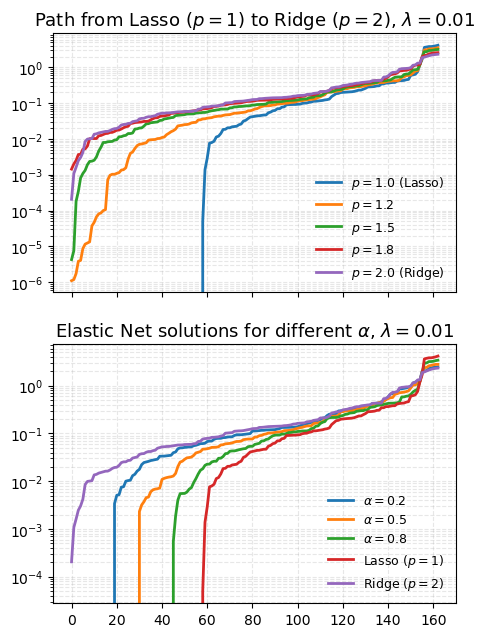

In [44]:
fig, axes = plt.subplots(
    2, 1, figsize=(5.2, 7.4),
    sharex=True, sharey=False
)

ax = axes[0]

p_order = [1.0, 1.2, 1.5, 1.8, 2.0]

for p in p_order:
    if p not in betas_p_dict:
        continue  

    beta = betas_p_dict[p]
    if p == 1.0:
        label = r"$p = 1.0$ (Lasso)"
    elif p == 2.0:
        label = r"$p = 2.0$ (Ridge)"
    else:
        label = rf"$p = {p}$"

    beta_sorted = np.sort(np.abs(beta))
    ax.plot(beta_sorted, label=label, linewidth=2)

ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", alpha=0.3)
ax.set_title(r"Path from Lasso ($p=1$) to Ridge ($p=2$), $\lambda = 0.01$", fontsize=13)
ax.legend(fontsize=9, frameon=False)

ax = axes[1]

betas_bottom = {}

for key, beta in betas_en.items():
    betas_bottom[key] = beta

betas_bottom[r"Lasso ($p=1$)"] = betas_p_dict[1.0]
betas_bottom[r"Ridge ($p=2$)"] = betas_p_dict[2.0]

for label, beta in betas_bottom.items():
    beta_sorted = np.sort(np.abs(beta))
    ax.plot(beta_sorted, label=label, linewidth=2)

ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", alpha=0.3)
ax.set_title(r"Elastic Net solutions for different $\alpha$, $\lambda = 0.01$", fontsize=13)
ax.legend(fontsize=9, frameon=False)

In [47]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

d = X_train.shape[1]
betas_lasso = np.zeros((n_splits, d))
betas_en    = np.zeros((n_splits, d))

for fold, (idx_tr, idx_te) in enumerate(kf.split(X_train)):
    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]

    beta_lasso_fold, _ = fista_lasso(
        X_tr, y_tr,
        lam=0.1,
        max_iter=20000,
        tol=1e-6,
        store_history=False
    )
    betas_lasso[fold] = beta_lasso_fold

    beta_en_fold, _ = fista_elasticnet(
        X_tr, y_tr,
        lam=1e-2,
        alpha=0.8,
        max_iter=20000,
        tol=1e-6,
        store_history=False
    )
    betas_en[fold] = beta_en_fold


def avg_pairwise_corr(B):
    """B: matriz (n_splits, d) con betas de un método"""
    corrs = []
    n = B.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            c = np.corrcoef(B[i], B[j])[0, 1]
            corrs.append(c)
    return np.mean(corrs), np.std(corrs)

corr_lasso_mean, corr_lasso_std = avg_pairwise_corr(betas_lasso)
corr_en_mean,    corr_en_std    = avg_pairwise_corr(betas_en)

print("Coef. stability (mean corr between splits)")
print(f"LASSO:      {corr_lasso_mean:.3f} ± {corr_lasso_std:.3f}")
print(f"EN α=0.8:   {corr_en_mean:.3f} ± {corr_en_std:.3f}")


FISTA converged in 5632 iterations.
FISTA ElasticNet converged in 15747 iterations.
FISTA converged in 5661 iterations.
FISTA ElasticNet converged in 13448 iterations.
FISTA converged in 4918 iterations.
FISTA ElasticNet converged in 18174 iterations.
FISTA converged in 5437 iterations.
FISTA ElasticNet converged in 19595 iterations.
FISTA converged in 5644 iterations.
FISTA ElasticNet converged in 13118 iterations.
Coef. stability (mean corr between splits)
LASSO:      0.987 ± 0.004
EN α=0.8:   0.968 ± 0.009


In [48]:
def avg_jaccard_topk(betas, k):
    sets = []
    for s in range(betas.shape[0]):
        idx_sorted = np.argsort(-np.abs(betas[s]))
        sets.append(set(idx_sorted[:k]))
    jacc = []
    n = len(sets)
    for i in range(n):
        for j in range(i+1, n):
            inter = len(sets[i] & sets[j])
            union = len(sets[i] | sets[j])
            jacc.append(inter / union)
    return np.mean(jacc), np.std(jacc)

for k in [10, 20, 30, 50]:
    j_lasso_mean, j_lasso_std = avg_jaccard_topk(betas_lasso, k)
    j_en_mean,    j_en_std    = avg_jaccard_topk(betas_en, k)
    print(f"\nTop-{k} Jaccard similarity between splits:")
    print(f"LASSO:    {j_lasso_mean:.3f} ± {j_lasso_std:.3f}")
    print(f"EN α=0.8: {j_en_mean:.3f} ± {j_en_std:.3f}")



Top-10 Jaccard similarity between splits:
LASSO:    0.891 ± 0.089
EN α=0.8: 0.836 ± 0.055

Top-20 Jaccard similarity between splits:
LASSO:    0.577 ± 0.063
EN α=0.8: 0.621 ± 0.042

Top-30 Jaccard similarity between splits:
LASSO:    0.473 ± 0.054
EN α=0.8: 0.582 ± 0.070

Top-50 Jaccard similarity between splits:
LASSO:    0.474 ± 0.038
EN α=0.8: 0.545 ± 0.080


---

In [49]:
results_lasso = pd.read_csv("results_lasso.csv")
results_p_intermediate = pd.read_csv("results_p_intermediate.csv")


In [50]:
df = pd.concat(
    [results_lasso[['method', 'time']],
     results_p_intermediate[['method', 'time']]],
    ignore_index=True
)

avg_time_s = df.groupby('method')['time'].mean().sort_index()
avg_time_ms = avg_time_s * 1000
print("\nTiempo medio por iteración (ms):")
print(avg_time_ms)


Tiempo medio por iteración (ms):
method
FISTA          1.509647
GD             1.263046
GD_BT          1.484935
ISTA           1.555041
Nesterov       1.293377
Subgradient    1.685550
Name: time, dtype: float64
